In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
from skimage.util import view_as_windows

In [2]:
# Download the data from FTP
!wget ftp://ftp.nersc.no/pub/ml_course/S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz

--2021-12-08 13:29:26--  ftp://ftp.nersc.no/pub/ml_course/S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz
           => ‘S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz.1’
Resolving ftp.nersc.no (ftp.nersc.no)... 10.47.30.29
Connecting to ftp.nersc.no (ftp.nersc.no)|10.47.30.29|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/ml_course ... done.
==> SIZE S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz ... 8758698
==> PASV ... done.    ==> RETR S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz ... done.
Length: 8758698 (8.4M) (unauthoritative)

S3A_OL_2_WFR_202006 100%[===================>]   8.35M  --.-KB/s    in 0.09s   

2021-12-08 13:29:26 (96.1 MB/s) - ‘S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz.1’ saved [8758698]



In [3]:
def fill_gaps(array, distance=5):
    """ Fill gaps in input raster

    Parameters
    ----------
    array : 2D numpy.array
        Raster with valid values and with nans
    distance : int
        Minimum size of gap to fill

    Returns
    -------
    array : 2D numpy.array
        Ratser with small gaps filled by nearest neigbour

    """
    dist, indi = distance_transform_edt(
        np.isnan(array),
        return_distances=True,
        return_indices=True)
    gpi = dist <= distance
    r,c = indi[:,gpi]
    array[gpi] = array[r,c]
    return array

def normalize_chl(chl, percentiles=(1,99)):
    """ Normalize input chlorophyll values """
    # Mask zero values with NaN
    chl[chl == 0] = np.nan
    # Apply log10 tranform to input values to match normal distribution
    chl = np.log10(chl)
    # Replace small gaps with nearest neigbour values
    chl = fill_gaps(chl, 2)
    # Compute min/max values
    chl_lims = np.nanpercentile(chl, percentiles)
    print(chl_lims)
    # replace values outside range with min/max
    chl[chl < chl_lims[0]] = chl_lims[0]
    chl[chl > chl_lims[1]] = chl_lims[1]
    
    return chl

In [4]:
# load arrays into Python
dataset = np.load('/data1/antonk/ml_course/S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz')
chl = dataset['chl'][:, ::2]
lbl = dataset['label'][:, ::2]
print(chl.shape, lbl.dtype, lbl.max())

chl = normalize_chl(chl)

(4091, 4050) float32 1.0
[-0.50393701  0.91338581]


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


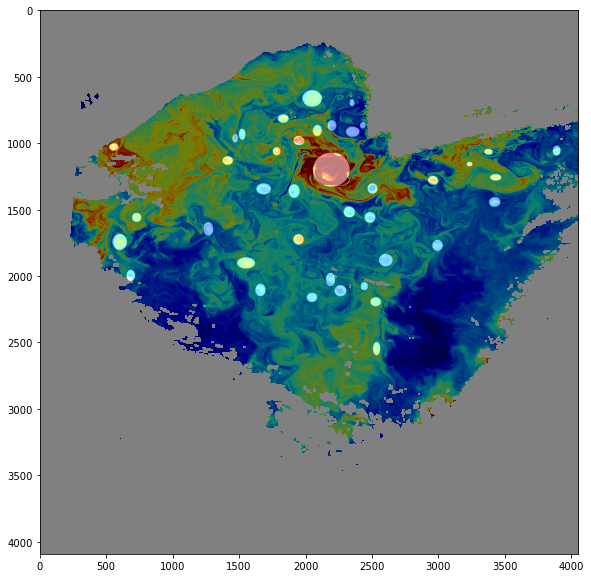

In [5]:
# plot maps of input chl and labels of eddies
plt.figure(figsize=(10,10))
plt.imshow(chl, cmap='jet')
plt.imshow(lbl, cmap='gray', alpha=0.5)
plt.show()

Shape of valid samples  (4754, 128, 128)
Shape of input/output data  (4754, 128, 128, 1) (4754, 128, 128, 1)
No-eddie pixels:  74395493 Eddie pixels  3494043


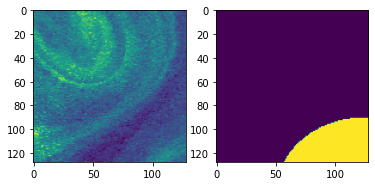

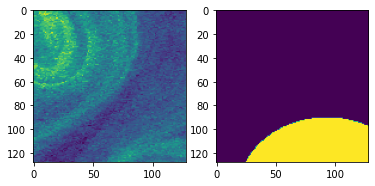

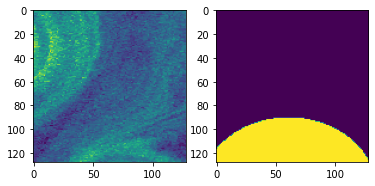

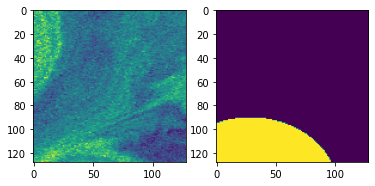

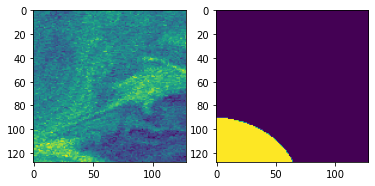

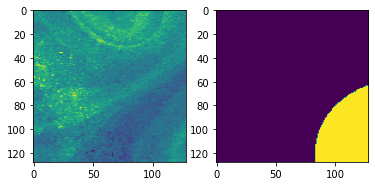

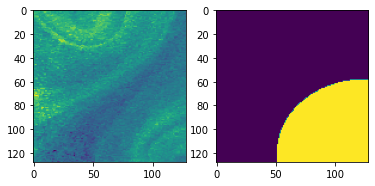

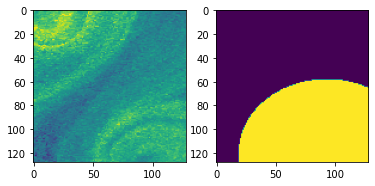

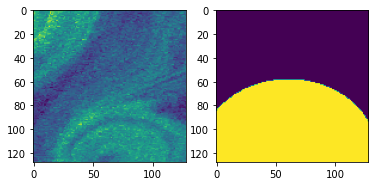

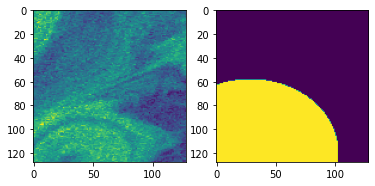

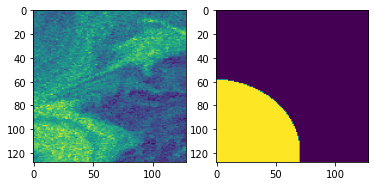

In [7]:
# Example split of the input image into small patches

ws = 128 # size of patch
stp = 32 # step, at which the patches are sampled
chl_w = view_as_windows(chl, ws, stp)
lbl_w = view_as_windows(lbl, ws, stp)

# reshape from (N_row_patches x N_col_patches x Patch_height x Patch_width)
# into (N_patches x Patch_height x Patch_width)
wshape = chl_w.shape
chl_w = chl_w.reshape(wshape[0]*wshape[1], wshape[2], wshape[3])
lbl_w = lbl_w.reshape(wshape[0]*wshape[1], wshape[2], wshape[3])

# Find valid patches (without NaN)
valid = np.where(np.isfinite(np.min(chl_w, axis=(1,2))))[0]
print('Shape of valid samples ', lbl_w[valid].shape)

# Subsample only valid patches and reshape into 
# N_samples x Height x Width x 1
x = chl_w[valid]
y = lbl_w[valid]
x.shape += (1,)
y.shape += (1,)
print('Shape of input/output data ', x.shape, y.shape)
print('No-eddie pixels: ', np.where(y == 0)[0].size, 'Eddie pixels ', np.where(y == 1)[0].size)

# Plot few patches with large labels
max_plots = 10
k = 0
for x1, y1 in zip(x,y):
    if y1.sum() > 1000:
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(x1[:,:,0])
        ax[1].imshow(y1[:,:,0])
        plt.show()
        k += 1
        if k > max_plots:
            break
